LIBRERIAS

In [20]:
# Standard library
import os
import glob
import json
import random
import csv
import re

# Third-party
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from torchvision import transforms, models
from torchvision.utils import make_grid


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Dispositivo: {device}")
print(f"📦 PyTorch: {torch.__version__}")

🚀 Dispositivo: cuda
📦 PyTorch: 2.5.1+cu121


GENERACIÓN DE DATASET

In [21]:
def create_heatmap_landmarks(coords_scaled, size=256, sigma=4):
    """
    Crea mapas Gaussianos para landmarks.
    
    Args:
        coords_scaled: array (N, 2) con coordenadas [x, y]
        size: tamaño de salida (default 256x256)
        sigma: desviación estándar gaussiana (menor = más definido)
    
    Returns:
        heatmap: imagen uint8 de size×size
    """
    heatmap = np.zeros((size, size), dtype=np.float32)
    x_grid, y_grid = np.meshgrid(np.arange(size), np.arange(size))
    coeff = 1.0 / (2 * sigma**2)
    
    for x, y in coords_scaled:
        if 0 <= x < size and 0 <= y < size:
            dist_sq = (x_grid - x)**2 + (y_grid - y)**2
            heatmap += np.exp(-dist_sq * coeff)
    
    # Normalizar a [0, 255]
    max_val = heatmap.max()
    if max_val > 0:
        heatmap = (heatmap / max_val) * 255
    
    return heatmap.astype(np.uint8)


def prepare_catflw_dataset(input_root="CatFLW dataset", output_root="datasets/catflw", sigma=4):
    """
    Convierte el dataset CatFLW en formato Pix2Pix (landmarks -> imagen).
    Usa mapas Gaussianos con landmarks claros y definidos.
    
    Args:
        input_root: carpeta raíz del dataset CatFLW original
        output_root: carpeta de salida del dataset preparado
        sigma: desviación estándar de las Gaussianas (bajo = más sólido)
    """

    if os.path.exists(output_root):
        print(f"✅ Dataset CatFLW ya existe en: {output_root}")
    else:
        print("🗂️ Creando dataset CatFLW con mapas Gaussianos...")

        # Crear carpetas base
        for split in ["train", "val", "test"]:
            os.makedirs(os.path.join(output_root, split, "A"), exist_ok=True)
            os.makedirs(os.path.join(output_root, split, "B"), exist_ok=True)

        # Directorios originales
        img_dir = os.path.join(input_root, "images")
        label_dir = os.path.join(input_root, "labels")

        # Listar imágenes válidas
        all_files = [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg", ".png"))]
        random.shuffle(all_files)
        n_total = len(all_files)
        n_train, n_val = int(0.8 * n_total), int(0.1 * n_total)

        # Dividir dataset
        splits = {
            "train": all_files[:n_train],
            "val": all_files[n_train:n_train + n_val],
            "test": all_files[n_train + n_val:]
        }

        print(f"📦 Total imágenes: {n_total}")
        print(f"  ├─ train: {len(splits['train'])}")
        print(f"  ├─ val:   {len(splits['val'])}")
        print(f"  └─ test:  {len(splits['test'])}")
        print(f"🔧 Usando sigma={sigma} para mapas Gaussianos (más bajo = más sólido)")

        # Procesar cada split
        for split, files in splits.items():
            print(f"\n✏️ Procesando split: {split}")
            for fname in tqdm(files):
                img_path = os.path.join(img_dir, fname)
                json_path = os.path.join(label_dir, os.path.splitext(fname)[0] + ".json")

                if not os.path.exists(json_path):
                    continue

                img = cv2.imread(img_path)
                if img is None:
                    continue

                try:
                    with open(json_path, "r") as f:
                        data = json.load(f)
                    coords = np.array(data["labels"], dtype=np.float32)
                    bbox = np.array(data["bounding_boxes"], dtype=np.float32)
                except (FileNotFoundError, KeyError, json.JSONDecodeError):
                    continue

                # Validar bbox
                h, w = img.shape[:2]
                bbox = bbox.flatten()
                if bbox.size < 4:
                    continue
                x_min, y_min, x_max, y_max = bbox[:4].astype(int)
                x_min, y_min = max(0, x_min), max(0, y_min)
                x_max, y_max = min(w, x_max), min(h, y_max)
                if x_max <= x_min + 1 or y_max <= y_min + 1:
                    continue

                # --- Recorte y escalado ---
                cropped = img[y_min:y_max, x_min:x_max]
                ch, cw = cropped.shape[:2]
                scale_x, scale_y = 256 / cw, 256 / ch
                coords_scaled = coords.copy()
                coords_scaled[:, 0] = (coords_scaled[:, 0] - x_min) * scale_x
                coords_scaled[:, 1] = (coords_scaled[:, 1] - y_min) * scale_y

                # --- Generar imágenes ---
                img_resized = cv2.resize(cropped, (256, 256))
                mask = create_heatmap_landmarks(coords_scaled, size=256, sigma=sigma)

                # --- Guardar ---
                outA = os.path.join(output_root, split, "A", fname)
                outB = os.path.join(output_root, split, "B", fname)
                Image.fromarray(mask).save(outA)
                Image.fromarray(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)).save(outB)

        print("\n✅ Dataset CatFLW procesado correctamente con mapas Gaussianos.")

    # Mostrar ejemplo visual
    print("\n🔍 Mostrando ejemplo del dataset...\n")
    try:
        example_split = "train"
        folderA = os.path.join(output_root, example_split, "A")
        folderB = os.path.join(output_root, example_split, "B")
        filesA = os.listdir(folderA)
        if not filesA:
            raise FileNotFoundError("No se encontraron imágenes en el split de entrenamiento.")

        example_file = random.choice(filesA)
        mask_img = Image.open(os.path.join(folderA, example_file))
        real_img = Image.open(os.path.join(folderB, example_file))

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(mask_img, cmap="gray")
        axes[0].set_title("A: Heatmap Gaussiano (Landmarks)")
        axes[0].axis("off")

        axes[1].imshow(real_img)
        axes[1].set_title("B: Imagen real")
        axes[1].axis("off")

        axes[2].imshow(real_img)
        axes[2].imshow(mask_img, cmap="gray", alpha=0.5)
        axes[2].set_title("Superposición A + B")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"⚠️ No se pudo mostrar ejemplo: {e}")

DATASET Y DATALOADER

In [22]:
class Pix2PixDataset(Dataset):
    def __init__(self, root, size=256, augment=False):
        """
        Dataset Pix2Pix (A: máscara/landmarks, B: imagen real)
        Si augment=True → aplica flips y jitter de color.
        """
        self.dir_A = os.path.join(root, "A")
        self.dir_B = os.path.join(root, "B")
        self.augment = augment

        all_names = [
            f for f in os.listdir(self.dir_A)
            if f.lower().endswith((".jpg", ".png"))
            and os.path.exists(os.path.join(self.dir_B, f))
        ]
        assert len(all_names) > 0, f"❌ No hay pares válidos en {root}"
        self.names = sorted(all_names)
        print(f"📊 Dataset cargado desde '{root}': {len(self.names)} pares")

        # Transformaciones
        base_A = [transforms.Resize((size, size), interpolation=transforms.InterpolationMode.NEAREST)]
        base_B = [transforms.Resize((size, size), interpolation=transforms.InterpolationMode.BILINEAR)]

        if augment:
            flip = transforms.RandomHorizontalFlip(p=0.5)
            base_A.append(flip)
            base_B.extend([flip, transforms.ColorJitter(0.2, 0.2, 0.2, 0.05)])

        base_A.extend([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
        base_B.extend([transforms.ToTensor(), transforms.Normalize([0.5]*3, [0.5]*3)])

        self.tA = transforms.Compose(base_A)
        self.tB = transforms.Compose(base_B)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        name = self.names[idx]
        A = Image.open(os.path.join(self.dir_A, name)).convert("L")
        B = Image.open(os.path.join(self.dir_B, name)).convert("RGB")
        return self.tA(A), self.tB(B)


MODELO PIX2PIX (U-Net + PatchGAN)

In [23]:
# ============================================================
# 🧩 Bloque U-Net (con BatchNorm y Dropout opcional)
# ============================================================
class UNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch, down=True, dropout=False):
        super().__init__()
        layers = []
        if down:
            layers.extend([
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(in_ch, out_ch, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_ch)
            ])
        else:
            layers.extend([
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(in_ch, out_ch, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_ch)
            ])
        if dropout:
            layers.append(nn.Dropout(0.5))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


# ============================================================
# 🧠 Generador tipo U-Net mejorado
# ============================================================
class UNetGenerator(nn.Module):
    def __init__(self, in_ch=1, out_ch=3):
        super().__init__()
        # Encoder (Downsampling)
        self.down1 = nn.Sequential(
            nn.Conv2d(in_ch, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=False)
        )
        self.down2 = UNetBlock(64, 128, down=True)
        self.down3 = UNetBlock(128, 256, down=True)
        self.down4 = UNetBlock(256, 512, down=True)
        self.down5 = UNetBlock(512, 512, down=True)
        self.down6 = UNetBlock(512, 512, down=True)
        self.down7 = UNetBlock(512, 512, down=True)

        # Bottleneck
        self.bottom = nn.Sequential(
            nn.ReLU(inplace=False),
            nn.Conv2d(512, 512, 4, 2, 1),
        )

        # Decoder (Upsampling)
        self.up1 = UNetBlock(512, 512, down=False, dropout=True)
        self.up2 = UNetBlock(1024, 512, down=False, dropout=True)
        self.up3 = UNetBlock(1024, 512, down=False, dropout=True)
        self.up4 = UNetBlock(1024, 512, down=False)
        self.up5 = UNetBlock(1024, 256, down=False)
        self.up6 = UNetBlock(512, 128, down=False)
        self.up7 = UNetBlock(256, 64, down=False)

        # Output
        self.final = nn.Sequential(
            nn.ReLU(inplace=False),
            nn.ConvTranspose2d(128, out_ch, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder path
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)

        # Bottleneck
        bottleneck = self.bottom(d7)

        # Decoder path (with skip connections)
        u1 = self.up1(bottleneck)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        return self.final(torch.cat([u7, d1], 1))


# ============================================================
# ⚡ Discriminador tipo PatchGAN (más detallado)
# ============================================================
class PatchDiscriminator(nn.Module):
    def __init__(self, in_ch=4):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_ch, 64, 4, 2, 1),          # no norm
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=False),

            # Patch más pequeño para más detalle local
            nn.Conv2d(256, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv2d(512, 1, 3, 1, 1, bias=False)  # salida 30×30 aprox
        )

    def forward(self, A, B):
        x = torch.cat([A, B], dim=1)
        return self.model(x)

ENTRENAMIENTO

In [24]:
def train_pix2pix(dataset_root="datasets/catflw", epochs=200, batch_size=32, lambda_L1=70, lambda_perc=10):
    """
    Entrena Pix2Pix con reanudación, checkpoints y visualizaciones periódicas.
    """

    # ===============================
    # 1) Dataset y DataLoaders
    # ===============================
    train_dataset = Pix2PixDataset(os.path.join(dataset_root, "train"), augment=True)
    val_dataset   = Pix2PixDataset(os.path.join(dataset_root, "val"))
    train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True)
    val_loader    = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

    # ===============================
    # 2) Modelos, Opts y pérdidas
    # ===============================
    G, D = UNetGenerator().to(device), PatchDiscriminator().to(device)
    opt_G = Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
    opt_D = Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

    criterion_GAN = nn.BCEWithLogitsLoss()
    criterion_L1  = nn.L1Loss()

    # Pérdida perceptual (VGG16)
    vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES).features[:16].to(device).eval()
    for p in vgg.parameters():
        p.requires_grad = False
    def perceptual_loss(fake, real):
        return F.l1_loss(vgg(fake), vgg(real))

    # Schedulers (decay lineal en la 2ª mitad)
    scheduler_G = LambdaLR(opt_G, lr_lambda=lambda e: 1 - max(0, e - epochs/2) / (epochs/2))
    scheduler_D = LambdaLR(opt_D, lr_lambda=lambda e: 1 - max(0, e - epochs/2) / (epochs/2))

    # Paths & log
    os.makedirs("checkpoints", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    log_file = "results/training_log.csv"

    # Scaler para AMP (debe existir antes de intentar cargar su estado)
    scaler = torch.cuda.amp.GradScaler()

    # ===============================
    # 3) Reanudación
    # ===============================
    start_epoch, best_val_loss = 1, float('inf')
    checkpoint_path = "checkpoints/last_checkpoint.pth"

    if os.path.exists(checkpoint_path):
        ckpt = torch.load(checkpoint_path, map_location=device)
        G.load_state_dict(ckpt["G_state"])
        D.load_state_dict(ckpt["D_state"])
        if ckpt.get("opt_G_state") and ckpt.get("opt_D_state"):
            opt_G.load_state_dict(ckpt["opt_G_state"])
            opt_D.load_state_dict(ckpt["opt_D_state"])
        if ckpt.get("sched_G_state") and ckpt.get("sched_D_state"):
            scheduler_G.load_state_dict(ckpt["sched_G_state"])
            scheduler_D.load_state_dict(ckpt["sched_D_state"])
        if ckpt.get("scaler_state"):
            scaler.load_state_dict(ckpt["scaler_state"])
        start_epoch = ckpt.get("epoch", 0) + 1
        best_val_loss = ckpt.get("best_val_loss", float('inf'))
        print(f"🔁 Reanudando desde época {ckpt['epoch']} (val_loss={best_val_loss:.4f})")
    else:
        ckpts = sorted(glob.glob("checkpoints/G_epoch*.pth"))
        if ckpts:
            last_ckpt = ckpts[-1]
            epoch_num = int(re.findall(r'\d+', os.path.basename(last_ckpt))[0])
            G.load_state_dict(torch.load(last_ckpt, map_location=device))
            d_path = last_ckpt.replace("G_", "D_")
            if os.path.exists(d_path):
                D.load_state_dict(torch.load(d_path, map_location=device))
            start_epoch = epoch_num + 1
            print(f"🔁 Reanudando desde epoch {epoch_num} (por archivos G/D_epoch).")
        else:
            print("🆕 Entrenamiento nuevo iniciado desde cero.")

    if not os.path.exists(log_file):
        with open(log_file, "w", newline="") as f:
            csv.writer(f).writerow(["epoch", "loss_D", "loss_G", "val_L1"])

    # ===============================
    # 4) Bucle principal
    # ===============================
    for epoch in range(start_epoch, epochs + 1):
        G.train(); D.train()
        loss_D_total, loss_G_total = 0.0, 0.0
        pbar = tqdm(train_loader, desc=f"Época {epoch}/{epochs}")

        for A, B in pbar:
            A, B = A.to(device, non_blocking=True), B.to(device, non_blocking=True)

            # Discriminador
            opt_D.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda"):
                fake_B = G(A).detach()
                pred_real = D(A, B)
                pred_fake = D(A, fake_B)

                # Label smoothing con ruido
                real_label = 0.9 + 0.1 * torch.rand_like(pred_real)
                fake_label = 0.1 * torch.rand_like(pred_fake)

                loss_D = 0.5 * (criterion_GAN(pred_real, real_label) +
                                criterion_GAN(pred_fake, fake_label))
            scaler.scale(loss_D).backward()
            scaler.step(opt_D)

            # Generador
            opt_G.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda"):
                fake_B = G(A)
                pred_fake = D(A, fake_B)
                loss_GAN = criterion_GAN(pred_fake, torch.ones_like(pred_fake))
                loss_L1v = criterion_L1(fake_B, B) * lambda_L1
                loss_P = perceptual_loss(fake_B, B) * lambda_perc
                loss_G = loss_GAN + loss_L1v + loss_P
            scaler.scale(loss_G).backward()
            scaler.step(opt_G)
            scaler.update()

            loss_D_total += loss_D.item()
            loss_G_total += loss_G.item()
            pbar.set_postfix({"D": f"{loss_D.item():.3f}", "G": f"{loss_G.item():.3f}"})

        # ------ Validación ------
        G.eval(); val_loss = 0.0
        with torch.no_grad():
            for A, B in val_loader:
                A, B = A.to(device), B.to(device)
                fake_B = G(A)
                val_loss += criterion_L1(fake_B, B).item()
        val_loss /= len(val_loader)

        # ------ Guardado sesión (reanudar) ------
        torch.save({
            "epoch": epoch,
            "G_state": G.state_dict(),
            "D_state": D.state_dict(),
            "opt_G_state": opt_G.state_dict(),
            "opt_D_state": opt_D.state_dict(),
            "sched_G_state": scheduler_G.state_dict(),
            "sched_D_state": scheduler_D.state_dict(),
            "scaler_state": scaler.state_dict(),
            "best_val_loss": best_val_loss
        }, "checkpoints/last_checkpoint.pth")

        # Best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(G.state_dict(), "checkpoints/G_best.pth")
            torch.save(D.state_dict(), "checkpoints/D_best.pth")
            print(f"💾 Mejor modelo guardado (val_L1={val_loss:.4f})")

        # Checkpoints periódicos
        if epoch % 50 == 0 or epoch == epochs:
            torch.save(G.state_dict(), f"checkpoints/G_epoch{epoch}.pth")
            torch.save(D.state_dict(), f"checkpoints/D_epoch{epoch}.pth")
            print(f"🗓️ Checkpoint guardado (época {epoch})")

        # Log CSV
        with open(log_file, "a", newline="") as f:
            csv.writer(f).writerow([
                epoch,
                loss_D_total / len(train_loader),
                loss_G_total / len(train_loader),
                val_loss
            ])

        scheduler_G.step(); scheduler_D.step()
        torch.cuda.empty_cache()
        print(f"📘 Época {epoch}: D={loss_D_total/len(train_loader):.4f}, G={loss_G_total/len(train_loader):.4f}, Val L1={val_loss:.4f}")

        # ------ Visualización cada 10 épocas ------
        if epoch % 10 == 0 or epoch == epochs:
            A_vis, B_vis = next(iter(val_loader))
            A_vis, B_vis = A_vis.to(device), B_vis.to(device)
            with torch.no_grad():
                fake_vis = G(A_vis)

            def denorm(x): return (x * 0.5 + 0.5).clamp(0, 1)
            grid = make_grid(torch.cat([
                denorm(A_vis[:4].repeat(1, 3, 1, 1)),
                denorm(B_vis[:4]),
                denorm(fake_vis[:4])
            ], dim=0), nrow=4)

            plt.figure(figsize=(10, 6))
            plt.imshow(grid.permute(1, 2, 0).cpu())
            plt.axis("off")
            plt.title(f"Pix2Pix — Época {epoch}")
            out_path = f"results/epoch_{epoch:03d}.png"
            plt.savefig(out_path, bbox_inches="tight")
            plt.close()
            print(f"🖼️ Imagen de progreso guardada en {out_path}")

    print("✅ Entrenamiento completado.")
    return G

VISUALIZACIÓN DE RESULTADOS

In [25]:
def show_samples(G, loader, device, n=5, title="Resultados Pix2Pix", save_path="results/samples.png"):
    """Visualiza comparaciones: Input A | Real B | Generado"""
    G.eval()
    with torch.no_grad():
        A, B = next(iter(loader))
        A, B = A.to(device), B.to(device)
        fake_B = G(A)

    denorm = lambda x: (x * 0.5 + 0.5).clamp(0, 1)

    n = min(n, A.size(0))
    fig, axes = plt.subplots(n, 3, figsize=(9, 3 * n))
    if n == 1:
        axes = axes.reshape(1, -1)

    fig.suptitle(title, fontsize=14, fontweight='bold')
    plt.subplots_adjust(top=0.93, hspace=0.2, wspace=0.1)

    for i in range(n):
        # Input A (1 canal → RGB)
        a = denorm(A[i])
        if a.size(0) == 1:
            a = a.repeat(3, 1, 1)
        a_img = a.permute(1, 2, 0).cpu()

        # Imagen real B
        b_img = denorm(B[i]).permute(1, 2, 0).cpu()

        # Imagen generada
        g_img = denorm(fake_B[i]).permute(1, 2, 0).cpu()

        # Mostrar
        axes[i, 0].imshow(a_img)
        axes[i, 0].set_title("Input A (Landmarks)")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(b_img)
        axes[i, 1].set_title("Real B")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(g_img)
        axes[i, 2].set_title("Generado")
        axes[i, 2].axis("off")

    os.makedirs("results", exist_ok=True)
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    print(f"🖼️ Ejemplo guardado en {save_path}")

EVALUAR CON TEST

In [26]:
def psnr(pred, target):
    """Calcula PSNR para imágenes normalizadas en [-1, 1]"""
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return 100.0
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def ssim(pred, target):
    """Calcula SSIM para imágenes normalizadas en [-1, 1]"""
    try:
        import piq
        return piq.ssim(pred, target, data_range=2.0).item()
    except ImportError:
        print("⚠️ Instala piq para SSIM: pip install piq")
        return 0.0
    except Exception as e:
        print(f"⚠️ Error calculando SSIM: {e}")
        return 0.0

def evaluate_on_test(G, dataset_root="datasets/catflw/test", batch_size=16):
    """Evalúa el generador en el conjunto de test"""
    G.eval()
    test_dataset = Pix2PixDataset(dataset_root)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                            num_workers=0, pin_memory=True)
    criterion_L1 = nn.L1Loss()
    total_l1, total_psnr, total_ssim, count = 0, 0, 0, 0

    with torch.no_grad():
        for A, B in tqdm(test_loader, desc="🧪 Evaluando"):
            A, B = A.to(device), B.to(device)
            fake_B = G(A)
            
            total_l1 += criterion_L1(fake_B, B).item()
            total_psnr += psnr(fake_B, B).item()
            total_ssim += ssim(fake_B, B)
            count += 1

    print(f"\n📊 Resultados Test ({len(test_dataset)} imágenes):")
    print(f"  ├─ L1 Loss:  {total_l1/count:.4f}")
    print(f"  ├─ PSNR:     {total_psnr/count:.2f} dB")
    print(f"  └─ SSIM:     {total_ssim/count:.4f}")

EJECUCIÓN PRINCIPAL


✅ Dataset CatFLW ya existe en: datasets/catflw

🔍 Mostrando ejemplo del dataset...



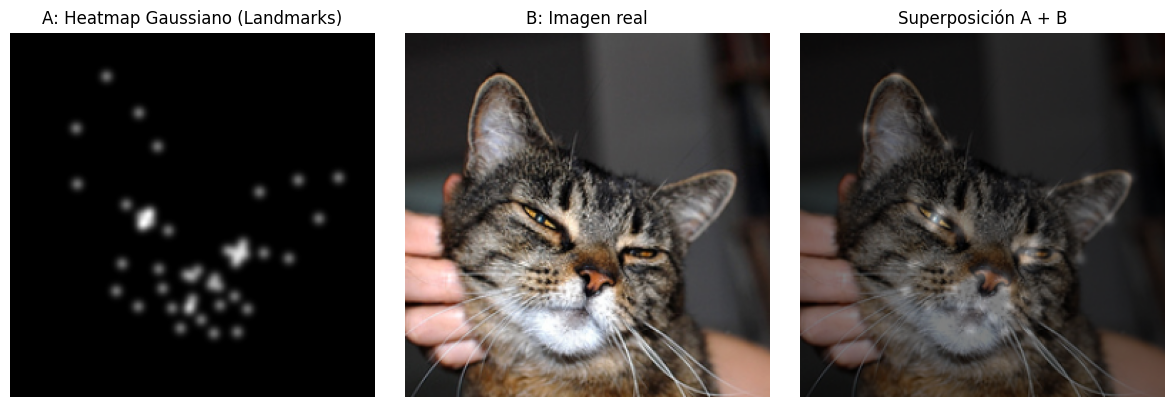

🚀 Reanudando / entrenando Pix2Pix...
📊 Dataset cargado desde 'datasets/catflw\train': 1663 pares
📊 Dataset cargado desde 'datasets/catflw\val': 207 pares


C:\Users\Samuel\AppData\Local\Temp\ipykernel_18736\3618053338.py:41: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\Samuel\AppData\Local\Temp\ipykernel_18736\3618053338.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting 

🔁 Reanudando desde época 200 (val_loss=0.4372)
✅ Entrenamiento completado.

🧪 Evaluando modelo en Test...
📊 Dataset cargado desde 'datasets/catflw\test': 209 pares


🧪 Evaluando:   7%|▋         | 1/14 [00:00<00:01,  7.35it/s]

⚠️ Error calculando SSIM: Expected values to be greater or equal to 0, got -0.9979216456413269


🧪 Evaluando:  14%|█▍        | 2/14 [00:00<00:01,  8.02it/s]

⚠️ Error calculando SSIM: Expected values to be greater or equal to 0, got -0.9948078989982605


🧪 Evaluando:  21%|██▏       | 3/14 [00:00<00:01,  8.33it/s]

⚠️ Error calculando SSIM: Expected values to be greater or equal to 0, got -0.9991133213043213


🧪 Evaluando:  29%|██▊       | 4/14 [00:00<00:01,  7.56it/s]

⚠️ Error calculando SSIM: Expected values to be greater or equal to 0, got -0.9963910579681396


🧪 Evaluando:  36%|███▌      | 5/14 [00:00<00:01,  7.98it/s]

⚠️ Error calculando SSIM: Expected values to be greater or equal to 0, got -0.9972370862960815


🧪 Evaluando:  43%|████▎     | 6/14 [00:00<00:01,  7.49it/s]

⚠️ Error calculando SSIM: Expected values to be greater or equal to 0, got -0.9989300966262817


🧪 Evaluando:  50%|█████     | 7/14 [00:00<00:00,  7.09it/s]

⚠️ Error calculando SSIM: Expected values to be greater or equal to 0, got -0.9996456503868103


🧪 Evaluando:  57%|█████▋    | 8/14 [00:01<00:00,  7.30it/s]

⚠️ Error calculando SSIM: Expected values to be greater or equal to 0, got -0.9983386397361755


🧪 Evaluando:  64%|██████▍   | 9/14 [00:01<00:00,  6.83it/s]

⚠️ Error calculando SSIM: Expected values to be greater or equal to 0, got -0.996258556842804


🧪 Evaluando:  71%|███████▏  | 10/14 [00:01<00:00,  7.33it/s]

⚠️ Error calculando SSIM: Expected values to be greater or equal to 0, got -0.9926698803901672


🧪 Evaluando:  79%|███████▊  | 11/14 [00:01<00:00,  7.42it/s]

⚠️ Error calculando SSIM: Expected values to be greater or equal to 0, got -0.9969182014465332


🧪 Evaluando:  86%|████████▌ | 12/14 [00:01<00:00,  7.70it/s]

⚠️ Error calculando SSIM: Expected values to be greater or equal to 0, got -0.9980984926223755


🧪 Evaluando: 100%|██████████| 14/14 [00:01<00:00,  8.00it/s]

⚠️ Error calculando SSIM: Expected values to be greater or equal to 0, got -0.9992333650588989
⚠️ Error calculando SSIM: Expected values to be greater or equal to 0, got -0.9929972290992737

📊 Resultados Test (209 imágenes):
  ├─ L1 Loss:  0.4917
  ├─ PSNR:     4.37 dB
  └─ SSIM:     0.0000
📊 Dataset cargado desde 'datasets/catflw\test': 209 pares


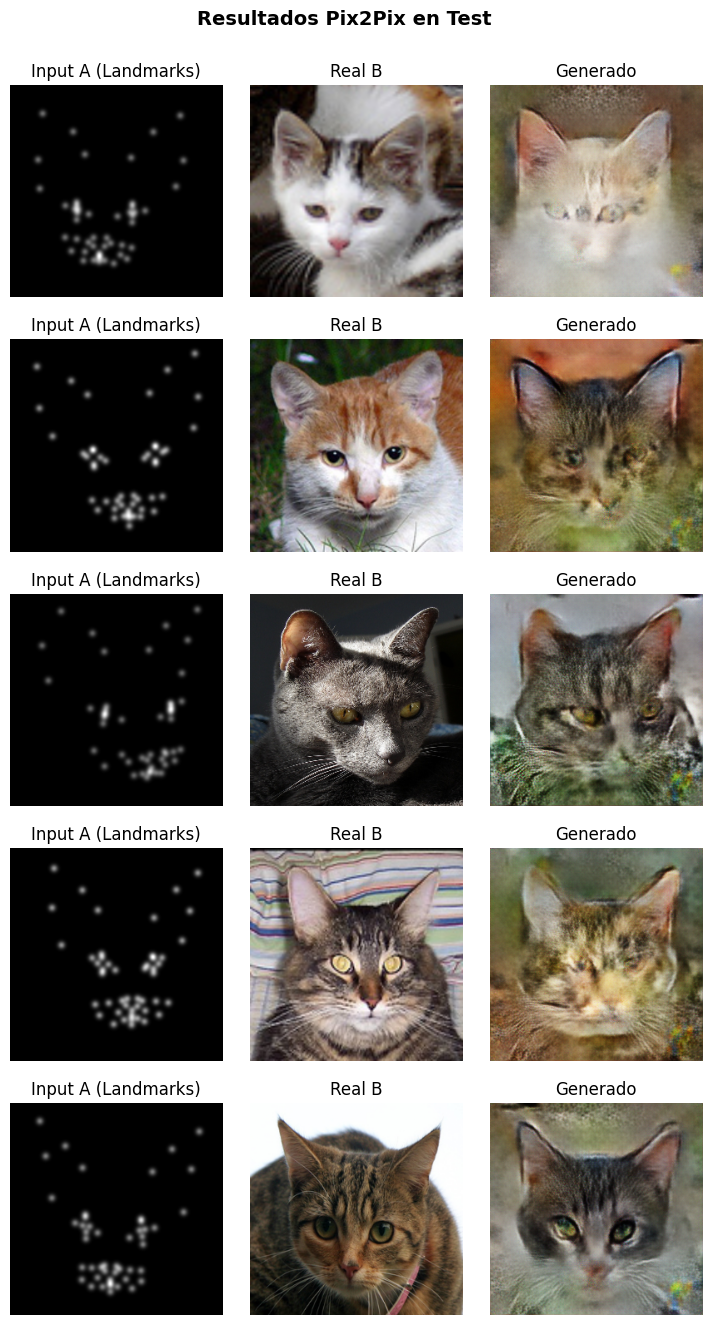

🖼️ Ejemplo guardado en results/samples.png


In [27]:
if __name__ == "__main__":
    dataset_root = "datasets/catflw"
    prepare_catflw_dataset("CatFLW dataset", dataset_root, sigma=3)

    # 🚀 Siempre reanudar si hay checkpoints
    print("🚀 Reanudando / entrenando Pix2Pix...")
    # 🔧 Ajuste: Reducir lambda_L1 de 100→60 y lambda_perc de 5→3
    # Esto reduce la presión sobre el generador y permite mejor equilibrio
    G = train_pix2pix(dataset_root=dataset_root, epochs=200, batch_size=32, lambda_L1=60, lambda_perc=3)

    print("\n🧪 Evaluando modelo en Test...")
    evaluate_on_test(G, dataset_root=os.path.join(dataset_root, "test"))
    
    #imprir ejemplos    
    show_samples(G, DataLoader(Pix2PixDataset(os.path.join(dataset_root, "test")), batch_size=16), device, n=5, title="Resultados Pix2Pix en Test")

In [ ]:
# Celda de diagnóstico
import matplotlib.pyplot as plt

# Cargar modelo y generar muestra
test_loader = DataLoader(Pix2PixDataset("datasets/catflw/test"), batch_size=4)
A, B = next(iter(test_loader))
A, B = A.to(device), B.to(device)

with torch.no_grad():
    fake_B = G(A)

# Verificar rangos de valores
print(f"Input A - Min: {A.min():.3f}, Max: {A.max():.3f}")
print(f"Real B - Min: {B.min():.3f}, Max: {B.max():.3f}")
print(f"Fake B - Min: {fake_B.min():.3f}, Max: {fake_B.max():.3f}")

# Visualizar
denorm = lambda x: (x * 0.5 + 0.5).clamp(0, 1)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(denorm(A[0]).repeat(3,1,1).permute(1,2,0).cpu())
axes[0].set_title("Input (Landmarks)")
axes[0].axis("off")

axes[1].imshow(denorm(B[0]).permute(1,2,0).cpu())
axes[1].set_title("Real")
axes[1].axis("off")

axes[2].imshow(denorm(fake_B[0]).permute(1,2,0).cpu())
axes[2].set_title("Generado")
axes[2].axis("off")

plt.tight_layout()
plt.show()